In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf
from pathlib import Path
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop


In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install gradio

In [51]:
import gradio as gr

### We will be attempting to train a model that detects if a concrete image contains cracks or not

#### Here are image examples

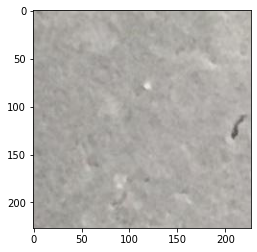

In [71]:
img_cracked = image.load_img('/content/drive/MyDrive/CIVL 498A/Concrete/Negative/00001.jpg')
img_noncracked = image.load_img('/content/drive/MyDrive/CIVL 498A/Concrete/Positive/00001.jpg')
plt.imshow(img_cracked) #cracked concrete example

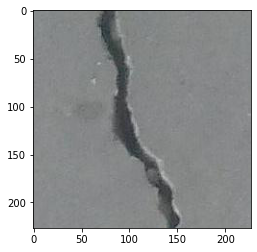

In [53]:
plt.imshow(img_noncracked) #non-cracked concrete example

In [ ]:
img = cv.imread('/content/drive/MyDrive/CIVL 498A/Concrete/Negative/00001.jpg')
print(img.shape)
cv.imread('/content/drive/MyDrive/CIVL 498A/Concrete/Negative/00001.jpg')

In [63]:
#create directory paths for the cracked and non-cracked image folders
cracked_dir = Path('/content/drive/MyDrive/CIVL 498A/Concrete/Positive')
noncracked_dir = Path('/content/drive/MyDrive/CIVL 498A/Concrete/Negative')

In [64]:
dir = Path('/content/drive/MyDrive/CIVL 498A/Concrete')

In [ ]:
#generating a list of directory paths for our individual jpg's in our cracked_dir
list(cracked_dir.glob(r'*.jpg'))
#list(noncracked_dir.glob(r'*.jpg')) would give same thing

In [10]:
#a function that creates a concatenated data frame that attaches labels to each image filepath
def generateDir_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name = 'filepath').astype(str)
    labels = pd.Series(label, name = 'label', index = filepaths.index)
    df = pd.concat([filepaths,labels],axis=1)
    return df

In [11]:
#create our positive and negative image path - label dataframes
neg_df = generateDir_df(noncracked_dir,'NEG')
pos_df = generateDir_df(cracked_dir,'POS')

In [12]:
#Cut down the number of images in negative data frame to be same amount as postive data frame
pos_df = pos_df.head(3000)
neg_df = neg_df.head(3000)
full_image_df = pd.concat([pos_df,neg_df], axis = 0).sample(frac=1.0,random_state=1).reset_index(drop=True) #concatentate, shuffle and reset index of data 
full_image_df

,filepath,label
0,/content/drive/MyDrive/CIVL 498A/Concrete/Posi...,POS
1,/content/drive/MyDrive/CIVL 498A/Concrete/Posi...,POS
2,/content/drive/MyDrive/CIVL 498A/Concrete/Posi...,POS
3,/content/drive/MyDrive/CIVL 498A/Concrete/Nega...,NEG
4,/content/drive/MyDrive/CIVL 498A/Concrete/Nega...,NEG
...,...,...
5995,/content/drive/MyDrive/CIVL 498A/Concrete/Posi...,POS
5996,/content/drive/MyDrive/CIVL 498A/Concrete/Nega...,NEG
5997,/content/drive/MyDrive/CIVL 498A/Concrete/Nega...,NEG
5998,/content/drive/MyDrive/CIVL 498A/Concrete/Posi...,POS


In [13]:
train_df, test_df = train_test_split(full_image_df, train_size=0.7,shuffle=True,random_state=1)

#### Preprocessing Images

In [57]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1/255, validation_split=0.2) 
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1/255)

In [15]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size =  (200,200),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 64,
    subset = 'training'
    )

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size =  (200,200),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 64,
    subset = 'validation'
    )

test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='label',
    target_size =  (200,200),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 64,
    shuffle = False,
    seed = 40
    )


Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.


#### Training

In [16]:
  train_data.class_indices

{'NEG': 0, 'POS': 1}

In [17]:
#Our Model: four layers of 2D Conv with maxpooling in between to reduce dimensionality. Last layer being a GAP2D to reduce to one dimension by averaging rows.
input = tf.keras.Input(shape=(200,200,3))
x = tf.keras.layers.Conv2D(filters= 16, kernel_size=(3,3), activation='relu')(input)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Conv2D(filters= 32, kernel_size=(3,3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Conv2D(filters= 64, kernel_size=(3,3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Conv2D(filters= 128, kernel_size=(3,3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

In [18]:
#defining the model and compiling it implementing our optimizer and loss parameters
model = tf.keras.Model(inputs=input, outputs=output)

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        18496 

In [19]:
#fitting our model
fit_model = model.fit(
    train_data,
    validation_data = val_data,
    epochs=5, 
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 2,restore_best_weights=True)] #automatically optimize parameter weights when val_loss is becoming worse
)

Epoch 1/5
53/53 [==============================] - 846s 16s/step - loss: 0.5291 - accuracy: 0.7530 - val_loss: 0.3497 - val_accuracy: 0.8690
Epoch 2/5
53/53 [==============================] - 16s 305ms/step - loss: 0.1263 - accuracy: 0.9696 - val_loss: 0.1296 - val_accuracy: 0.9798
Epoch 3/5
53/53 [==============================] - 16s 303ms/step - loss: 0.1154 - accuracy: 0.9634 - val_loss: 0.1446 - val_accuracy: 0.9607
Epoch 4/5
53/53 [==============================] - 16s 305ms/step - loss: 0.1206 - accuracy: 0.9682 - val_loss: 0.1166 - val_accuracy: 0.9833
Epoch 5/5
53/53 [==============================] - 17s 316ms/step - loss: 0.0887 - accuracy: 0.9768 - val_loss: 0.1092 - val_accuracy: 0.9869


#### Evaluation and Results

In [20]:
#Figure representing the loss and accuracy over the epochs
fig = px.line(
    fit_model.history,
    y = ['loss', 'accuracy'],
    labels = {'index': "Epoch", 'value': "loss"},
    title = "Accuracy and Loss Over Time"
)
fig.show()

In [21]:
eval = model.evaluate(test_data)

29/29 [==============================] - 361s 13s/step - loss: 0.0437 - accuracy: 0.9861


In [23]:
print('The model Accuracy is {:.2f}%'.format(eval[1]*100))
print('The model Loss is {:.5f}'.format(eval[0]))

The model Accuracy is 98.61%
The model Loss is 0.04368


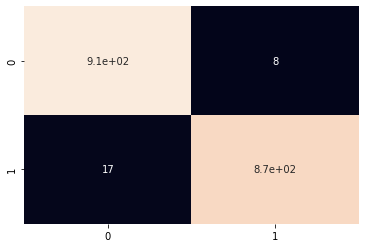

In [24]:
pred = ((model.predict(test_data)) >= 0.5).astype(int)
actual = test_data.labels
sns.heatmap(confusion_matrix(actual,pred), annot=True,cbar=False)